# Chapter4. Dynamic Programming with Q value
---

### Import grid environment

In [1]:
import import_ipynb
from grid_env import GridEnv, policy_visualize, ActionValueFunction_visualize

import numpy as np
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

importing Jupyter notebook from GridEnv.ipynb


### Generate Random Policy $\pi(a|s)$

In [2]:
# 4 actions and 100 states -> 4x100 size
def policy_generation(env):
    policy = np.zeros([len(env.obs_space), len(env.action_space)])
    for i in range(len(env.obs_space)):
        policy[i] = [0.25]*4
            
    return policy

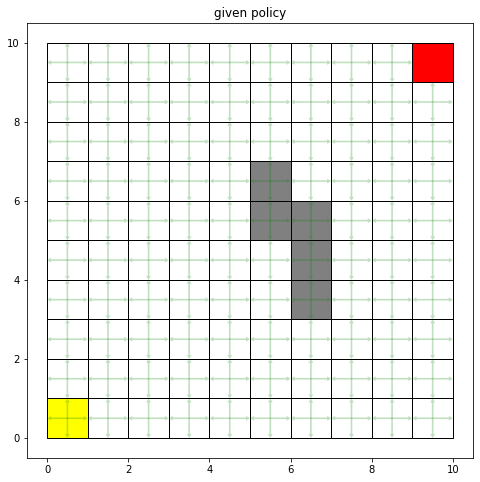

In [3]:
env = GridEnv()
policy = policy_generation(env)
policy_visualize(env, policy)

### 1. Policy Iteration with Q value

#### Basic Equation
- $V_{k+1}(s) = \sum_a \pi(a|s) \sum_{s'} P(s'|s,a) \left[r + \gamma V_{k}(s')\right]$

- $V_{k}(s) = \sum_{a} \pi_{k}(a|s) Q_{k}(s,a)$

- $Q_{k+1}(s,a) = \sum_{s'} P(s'|s,a)\left[r + \gamma V_{k}(s') \right]$

#### Policy Evaluation
- $Q_{k+1}(s,a) = \sum_{s'} P(s'|s,a)\left[r + \gamma \sum_{a'} \pi(a'|s')Q_{k}(s',a') \right]$

In [4]:
def q_policy_evaluation(env, policy, gamma=0.99, theta=1e-6):
    """
    Policy Evaluation with Q value
    """
    # Extract environment information
    n_state = len(env.obs_space)
    n_action = len(env.action_space)
    
    # initialize
    Q = np.zeros([n_state, n_action])
    Q_history = [Q]
    delta_history = []
    
    while True:
        delta = 0
        Q_nxt = np.zeros([n_state, n_action])
        for s in range(len(env.obs_space)):
            if s == 99:
                continue
            for a, _ in enumerate(policy[s]):
                s_nxt, reward, prob = env.transition(s, a)
                
                SigmaPiQ_nxt = 0
                for a_nxt, pi_nxt in enumerate(policy[s_nxt]):
                    SigmaPiQ_nxt += pi_nxt*Q[s_nxt][a_nxt]
                
                Q_nxt[s][a] = prob*(reward + gamma*SigmaPiQ_nxt)
                
            delta = np.max([delta, np.abs(Q_nxt[s][a] - Q[s][a])])
        Q = Q_nxt
        
        Q_history.append(Q)
        delta_history.append(delta)
        if delta < theta:
            break
    
    return Q, Q_history, delta_history

#### 1.1. Run policy evaluation with Q value


In [5]:
start = time.time()
Q, Q_history, delta_history = q_policy_evaluation(env, policy, gamma=0.99, theta=1e-6)
print("It took [{:.2f}]s.".format(time.time()-start))
print ("Policy evaluation converged in [{}] loops.".format(len(Q_history)))

It took [6.11]s.
Policy evaluation converged in [1349] loops.


#### 1.2. Plot the convergence of policy evaluation with Q value

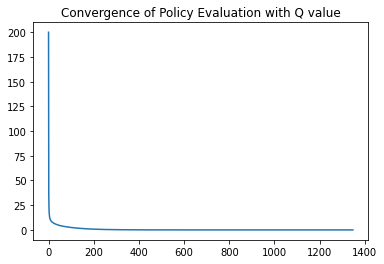

In [6]:
plt.plot(delta_history)
plt.title("Convergence of Policy Evaluation with Q value")
plt.show()

#### 1.3. Plot how value function changes over iteration

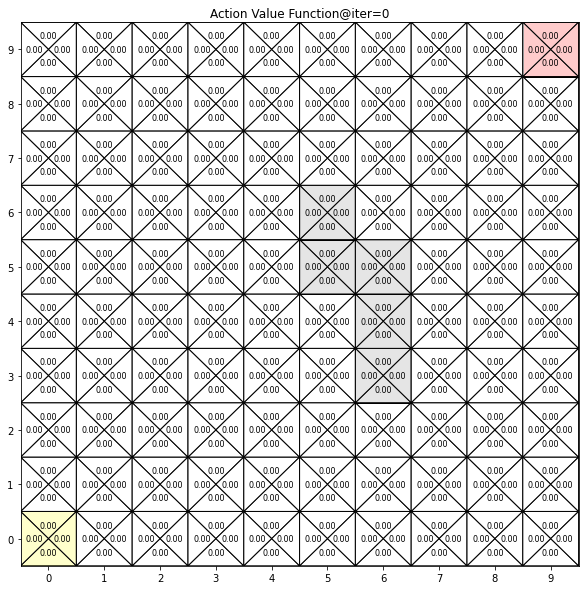

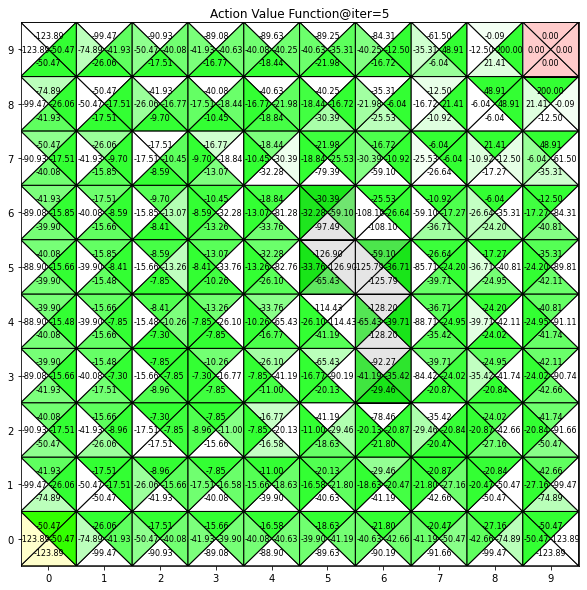

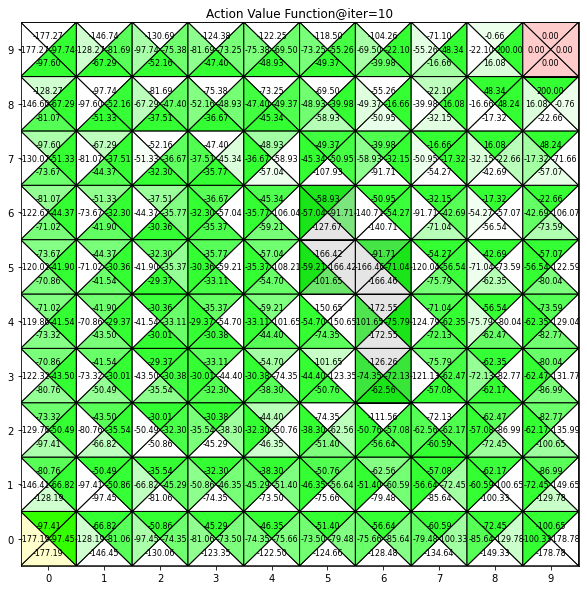

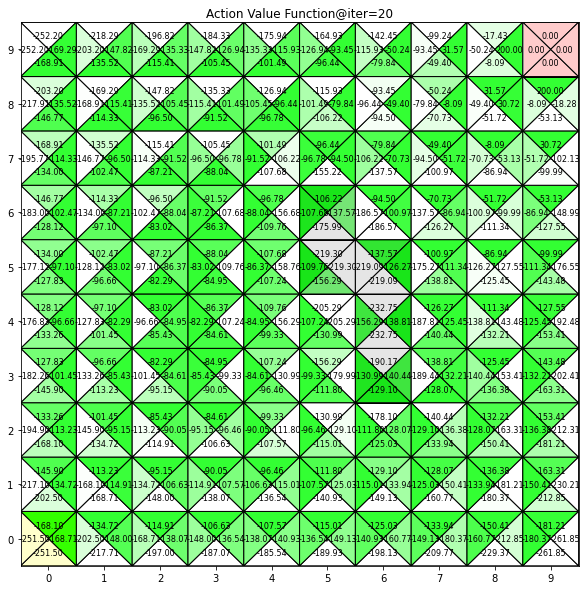

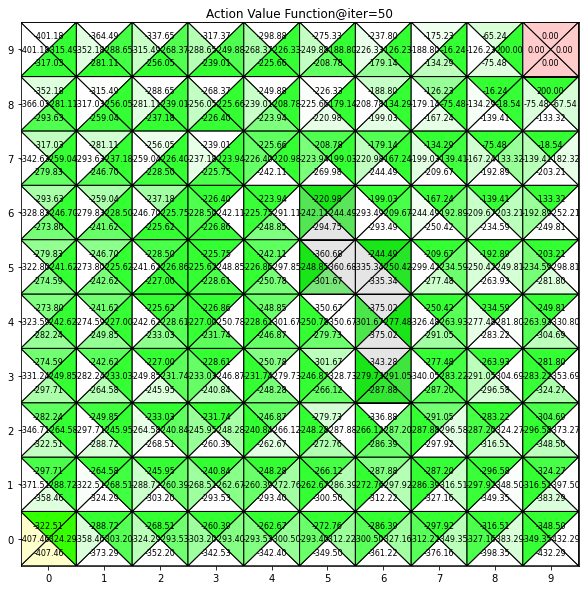

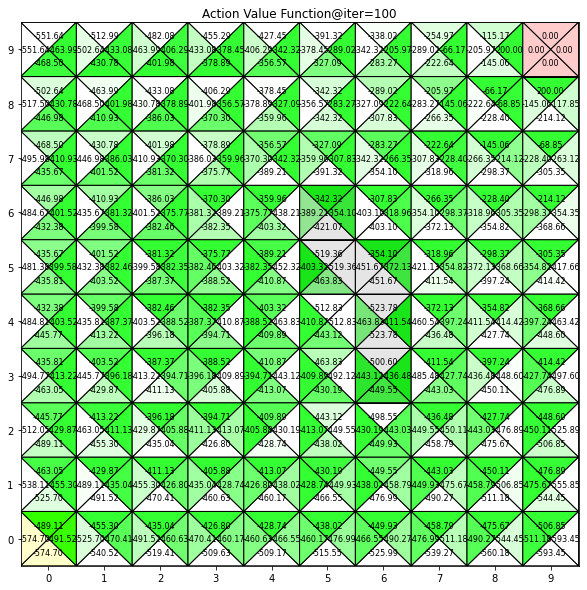

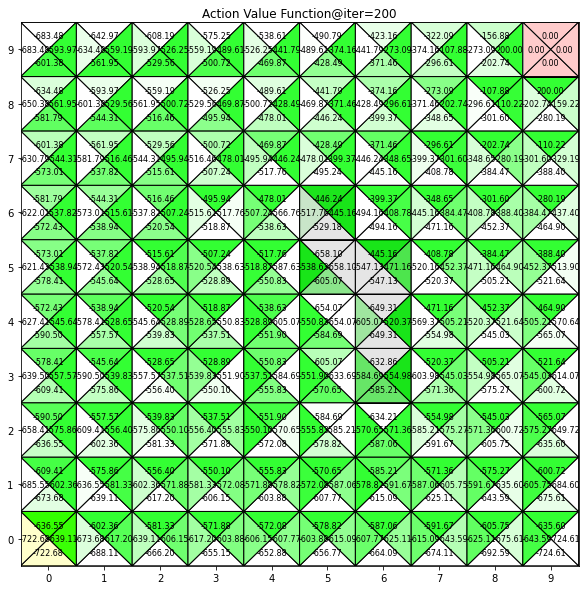

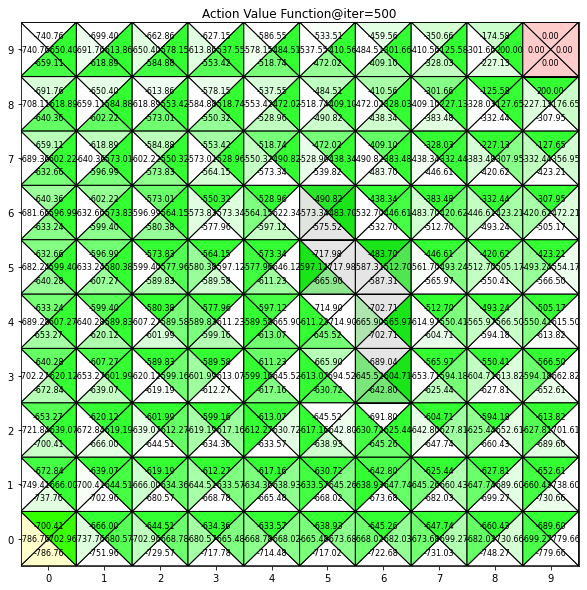

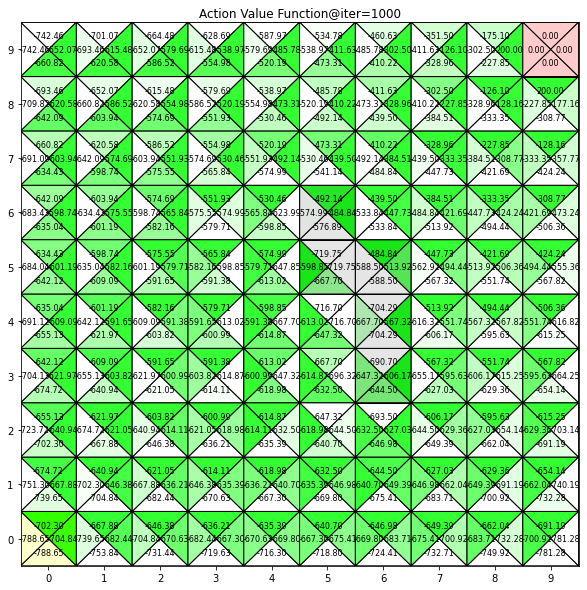

In [7]:
for itr in [0, 5, 10, 20, 50, 100, 200, 500, 1000]:
    Q_visual = Q_history[itr]
    ActionValueFunction_visualize(env, Q_visual, title="Action Value Function@iter={}".format(itr))

### 2. Policy Improvement with Q value

- $\pi'(a|s) = 1 \left (a = \max_{a} Q(s,a)\right)$

In [8]:
def q_policy_improvement(env, Q):
    """
    Policy Improvement with Q value
    """
    new_policy = np.zeros([len(env.obs_space), len(env.action_space)])
    
    # for all states except for obstacle and terminal states
    for s in range(len(env.obs_space)):
        if s == 99:
            continue
            
        max_actions = np.where(Q[s] == np.max(Q[s]))[0]
        remain_actions = [a for a in env.action_space if a not in max_actions]    
        for a in max_actions:
            new_policy[s][a] = 1/len(max_actions)
        for a in remain_actions:
            new_policy[s][a] = 0

    return new_policy

#### 2.1. Plot greedy action to given value function

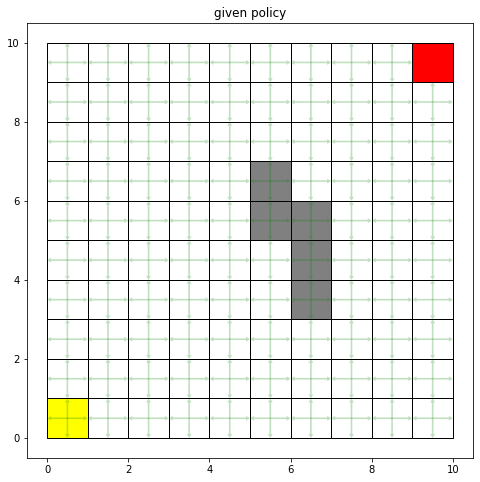

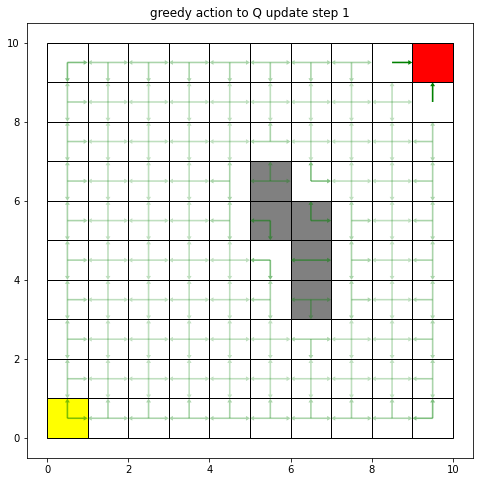

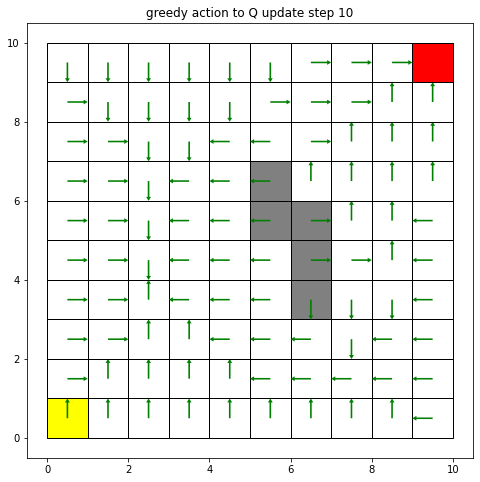

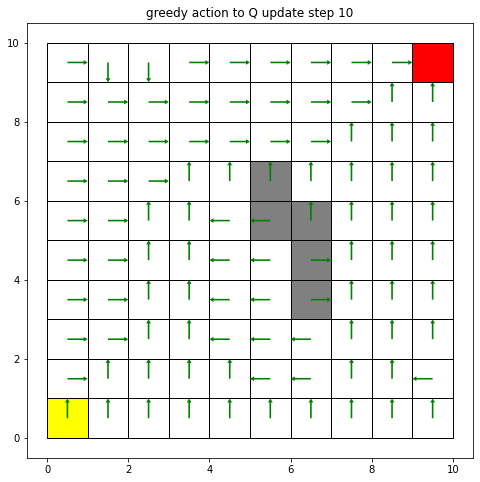

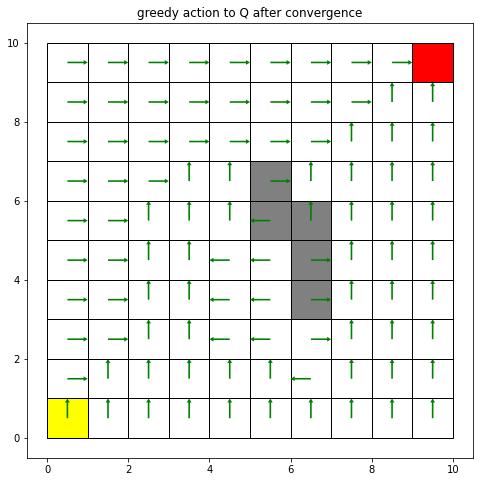

In [9]:
'''
Greedy action to value function means that policy improvement with that value function
'''
policy_visualize(env, policy)
new_policy = q_policy_improvement(env, Q_history[1])
policy_visualize(env, new_policy, "greedy action to Q update step 1")
new_policy = q_policy_improvement(env, Q_history[10])
policy_visualize(env, new_policy, "greedy action to Q update step 10")
new_policy = q_policy_improvement(env, Q_history[100])
policy_visualize(env, new_policy, "greedy action to Q update step 10")
new_policy = q_policy_improvement(env, Q_history[-1])
policy_visualize(env, new_policy, "greedy action to Q after convergence")

### 3. Policy Iteration

In [10]:
def q_policy_iteration(env, gamma=0.99, theta=1e-6):
    # initialize
    policy = policy_generation(env)
    while True:
        # policy evaluation
        start = time.time()
        Q, Q_history, delta_history = q_policy_evaluation(env, policy, gamma=0.99, theta=1e-6)
        # policy improvement
        new_policy = q_policy_improvement(env, Q)
        # termination condition
        if (new_policy == policy).all(): # if the policy does not change
            break
        policy = new_policy
    
    return Q, new_policy

#### 3.1. Run policy iteration

In [11]:
start = time.time()
optimal_Q, optimal_policy = q_policy_iteration(env)
print("It took [{:.2f}]s.".format(time.time()-start))

It took [6.62]s.


#### 3.2. Plot environment and the results of policy iteration

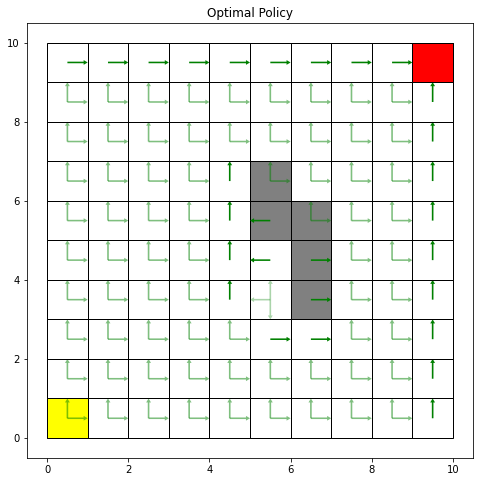

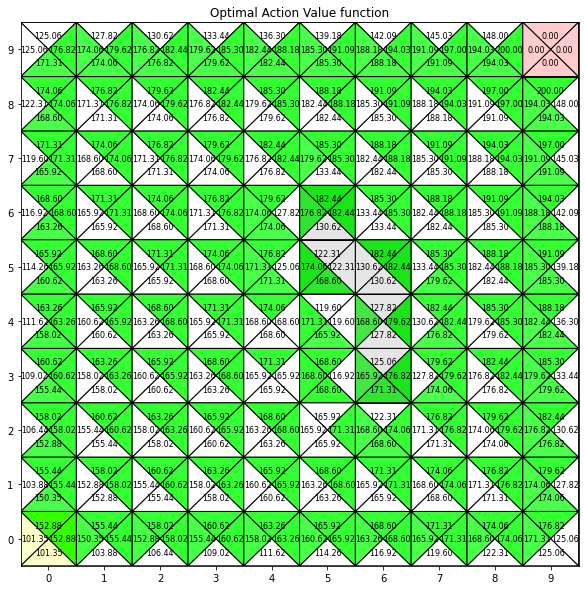

In [12]:
policy_visualize(env, optimal_policy, "Optimal Policy")
ActionValueFunction_visualize(env, optimal_Q, title="Optimal Action Value function")